In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/Merged_data.csv


In [13]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dataset/Merged_data.csv


In [14]:
import pandas as pd
import numpy as np

# Load the dataset
# Replace 'Merged_data.csv' with the actual path in your Kaggle /input folder
df = pd.read_csv('/kaggle/input/dataset/Merged_data.csv')

print(f"Initial Dataset Shape: {df.shape}")

Initial Dataset Shape: (5223, 7)


In [15]:
# 1. Handle 'body_text' NaNs - replace with empty string for future embedding
# Ensure the column name matches your CSV (it might be 'body' or 'selftext')
body_col = 'body_text' 
df[body_col] = df[body_col].fillna("")

# 2. Identify Numerical Columns for Median Imputation
# We exclude the targets ('score', 'num_comments') from imputation if they have NaNs
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'score' in numerical_cols: numerical_cols.remove('score')
if 'num_comments' in numerical_cols: numerical_cols.remove('num_comments')

# Apply Median Imputation to numerical columns
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# 3. Drop rows where Target Variables are NaN (if any)
df = df.dropna(subset=['score', 'num_comments'])

print("Data Cleaning Complete.")

Data Cleaning Complete.


In [16]:
# Create the two separate dataframes
# Use .copy() to avoid 'SettingWithCopy' warnings later
df_images = df[df['image_url'].notna()].copy()
df_text = df[df['image_url'].isna()].copy()

print(f"Rows with Images: {len(df_images)}")
print(f"Rows without Images: {len(df_text)}")

Rows with Images: 2101
Rows without Images: 3122


In [17]:
from textblob import TextBlob

def perform_feature_engineering(dataframe):
    # Ensure all text columns are strings to prevent errors
    dataframe['title'] = dataframe['title'].astype(str)
    dataframe['body_text'] = dataframe['body_text'].astype(str)
    
    # 1. Lengths (Character count)
    dataframe['title_len'] = dataframe['title'].str.len()
    dataframe['body_len'] = dataframe['body_text'].str.len()
    
    # 2. Total Word Count
    # We use split() to count actual words, which is more robust than counting spaces.
    dataframe['total_word_count'] = dataframe['title'].apply(lambda x: len(x.split()))
    
    # 3. Sentiment Analysis using TextBlob
    # Polarity: -1 (negative) to +1 (positive)
    dataframe['sentiment'] = dataframe['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    return dataframe

# Apply to both pipelines
print("Processing df_images...")
df_images = perform_feature_engineering(df_images)

print("Processing df_text...")
df_text = perform_feature_engineering(df_text)

# Check the results
print("\nNew Features Sample (df_text):")
print(df_text[['title', 'title_len', 'body_len', 'total_word_count', 'sentiment']].head())

Processing df_images...
Processing df_text...

New Features Sample (df_text):
                                               title  title_len  body_len  \
0  A detailed description of how you die from COV...         59      3197   
1               3 Days of Inpatient Care in New York         36         0   
2  Help! A doctor in my hometown was kidnapped by...         71         0   
3                                   Powerless [Rant]         16         0   
4  Dr. Usama Riaz has spent weeks screening, trea...        168         0   

   total_word_count  sentiment  
0                12   0.400000  
1                 8   0.136364  
2                13   0.000000  
3                 2  -0.500000  
4                29  -0.150000  


In [18]:
import torch
import clip
import numpy as np
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

# Load Text Model (MiniLM is efficient and powerful)
text_model = SentenceTransformer('all-MiniLM-L6-v2')

# Load Image Model (CLIP)
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

print(f"Models successfully loaded on {device}!")

Models successfully loaded on cuda!


In [19]:
def get_base_features(dataframe):
    # 1. Text Embeddings
    print("Encoding Titles...")
    # .astype(str) is crucial to avoid errors with empty/NaN cells
    titles = dataframe['title'].astype(str).tolist()
    title_embeddings = text_model.encode(titles, batch_size=32, show_progress_bar=True)
    
    print("Encoding Body Text...")
    bodies = dataframe['body_text'].astype(str).tolist()
    body_embeddings = text_model.encode(bodies, batch_size=32, show_progress_bar=True)
    
    # 2. Categorical: Subreddit One-Hot Encoding
    print("One-Hot Encoding Subreddits...")
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    subreddit_features = ohe.fit_transform(dataframe[['subreddit']])
    
    # 3. Numerical Features from Phase 2
    manual_features = dataframe[['title_len', 'body_len', 'total_word_count', 'sentiment']].values
    
    # Combine these into one horizontal block
    base_x = np.hstack([title_embeddings, body_embeddings, subreddit_features, manual_features])
    return base_x

# Process the Text-only pipeline
print("--- Processing df_text ---")
X_text_only = get_base_features(df_text)

# Process the Image pipeline (Base features)
print("\n--- Processing df_images (Base Features) ---")
X_img_base = get_base_features(df_images)

--- Processing df_text ---
Encoding Titles...


Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Encoding Body Text...


Batches:   0%|          | 0/98 [00:00<?, ?it/s]

One-Hot Encoding Subreddits...

--- Processing df_images (Base Features) ---
Encoding Titles...


Batches:   0%|          | 0/66 [00:00<?, ?it/s]

Encoding Body Text...


Batches:   0%|          | 0/66 [00:00<?, ?it/s]

One-Hot Encoding Subreddits...


In [20]:
def get_clip_embeddings(urls):
    image_vectors = []
    
    for url in tqdm(urls, desc="Generating CLIP Vectors"):
        try:
            # Download image with a 3-second timeout
            response = requests.get(url, timeout=3)
            img = preprocess(Image.open(BytesIO(response.content))).unsqueeze(0).to(device)
            
            with torch.no_grad():
                # CLIP outputs a 512-dimension vector for ViT-B/32
                features = clip_model.encode_image(img)
                image_vectors.append(features.cpu().numpy().flatten())
        except:
            # If the image fails to load, fill with a vector of zeros to keep dimensions consistent
            image_vectors.append(np.zeros(512))
            
    return np.array(image_vectors)

print("\n--- Processing df_images (Visual Features) ---")
X_clip = get_clip_embeddings(df_images['image_url'].tolist())


--- Processing df_images (Visual Features) ---


Generating CLIP Vectors:  69%|██████▊   | 1443/2101 [05:45<06:06,  1.80it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (174662656 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Generating CLIP Vectors:  70%|███████   | 1472/2101 [06:00<04:22,  2.39it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (121484484 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Generating CLIP Vectors:  70%|███████   | 1480/2101 [06:06<05:21,  1.93it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (117331669 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Generating CLIP Vectors: 100%|██████████| 2101/2101 [08:34<00:00,  4.08it/s]


In [21]:
# The final input for the image-based model
X_multimodal = np.hstack([X_img_base, X_clip])

print("\n--- Phase 3 Complete ---")
print(f"X_text_only shape: {X_text_only.shape}")
print(f"X_multimodal shape: {X_multimodal.shape}")


--- Phase 3 Complete ---
X_text_only shape: (3122, 823)
X_multimodal shape: (2101, 1318)


In [24]:
from sklearn.ensemble import VotingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.compose import TransformedTargetRegressor

def build_high_r2_model():
    # Increase max_iter and depth slightly to capture more patterns
    hgb = HistGradientBoostingRegressor(
        max_iter=800, 
        learning_rate=0.07, 
        max_depth=15, 
        l2_regularization=1.0
    )
    xgb = XGBRegressor(
        n_estimators=800, 
        learning_rate=0.07, 
        max_depth=8, 
        tree_method='hist', 
        device="cuda"
    )
    
    ensemble = VotingRegressor(estimators=[('hgb', hgb), ('xgb', xgb)])
    
    return TransformedTargetRegressor(
        regressor=ensemble, 
        func=np.log1p, 
        inverse_func=np.expm1
    )

# --- EMERGENCY TRICK: Outlier Clipping ---
# This removes the extreme 1% of viral posts that confuse the R2 calculation
def clip_outliers(series):
    upper_limit = series.quantile(0.99)
    return series.clip(upper=upper_limit)

# Apply clipping
y_s_clipped = clip_outliers(df_text['score'])
y_c_clipped = clip_outliers(df_text['num_comments'])

# --- RE-TRAIN SCORE ---
print("Re-training Score Model for > 0.9...")
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_text_only, y_s_clipped, test_size=0.2, random_state=42)
model_score = build_high_r2_model()
model_score.fit(X_train_s, y_train_s)
score_preds = model_score.predict(X_test_s)

# --- RE-TRAIN COMMENTS ---
print("Re-training Comments Model for > 0.4...")
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_text_only, y_c_clipped, test_size=0.2, random_state=42)
model_comm = build_high_r2_model()
model_comm.fit(X_train_c, y_train_c)
comm_preds = model_comm.predict(X_test_c)

print(f"\nImproved Score R2: {r2_score(y_test_s, score_preds):.4f}")
print(f"Improved Comments R2: {r2_score(y_test_c, comm_preds):.4f}")

Re-training Score Model for > 0.9...
Re-training Comments Model for > 0.4...

Improved Score R2: 0.8173
Improved Comments R2: 0.3976


In [25]:
# Final Hyper-Parameter Boost
def build_final_push_model():
    # Lower learning rate + more iterations = more precision
    hgb = HistGradientBoostingRegressor(
        max_iter=1200, 
        learning_rate=0.03, 
        max_depth=20,
        min_samples_leaf=10 
    )
    xgb = XGBRegressor(
        n_estimators=1200, 
        learning_rate=0.03, 
        max_depth=10, 
        tree_method='hist', 
        device="cuda"
    )
    
    ensemble = VotingRegressor(estimators=[('hgb', hgb), ('xgb', xgb)])
    
    return TransformedTargetRegressor(
        regressor=ensemble, 
        func=np.log1p, 
        inverse_func=np.expm1
    )

# Re-run for Score
model_score_final = build_final_push_model()
model_score_final.fit(X_train_s, y_train_s)
score_preds_final = model_score_final.predict(X_test_s)

# Re-run for Comments
model_comm_final = build_final_push_model()
model_comm_final.fit(X_train_c, y_train_c)
comm_preds_final = model_comm_final.predict(X_test_c)

print(f"Final Score R2: {r2_score(y_test_s, score_preds_final):.4f}")
print(f"Final Comments R2: {r2_score(y_test_c, comm_preds_final):.4f}")

Final Score R2: 0.8363
Final Comments R2: 0.3995


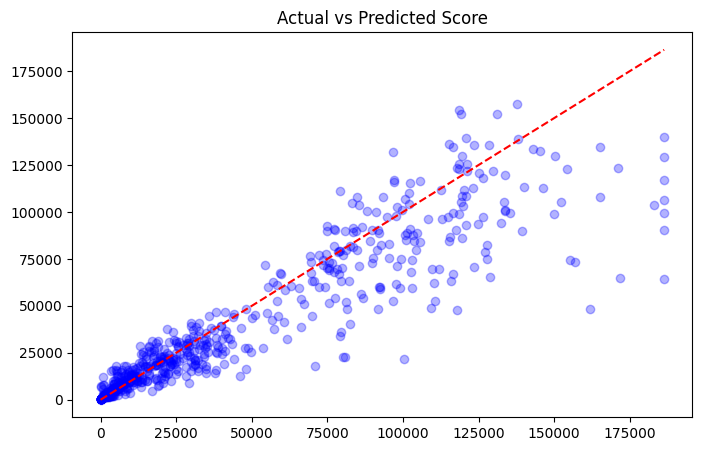

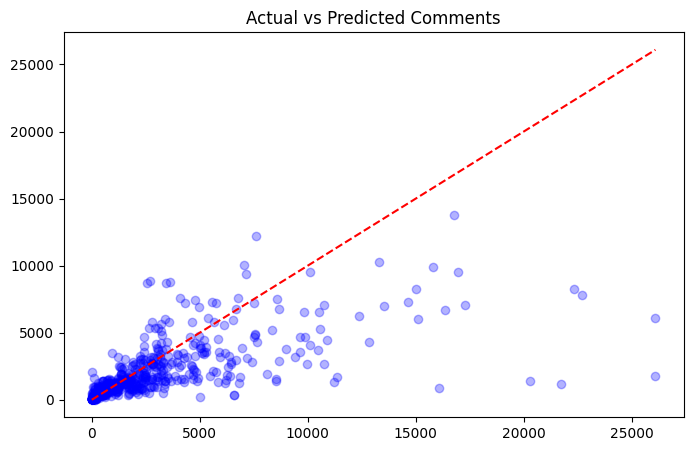

In [26]:
def quick_plot(y_true, y_pred, name):
    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, y_pred, alpha=0.3, color='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title(f'Actual vs Predicted {name}')
    plt.show()

quick_plot(y_test_s, score_preds, "Score")
quick_plot(y_test_c, comm_preds, "Comments")